In [61]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm




def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):
    transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)),Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(MNIST('./data/', train=True,download=True,transform=transform),batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(MNIST('./data/', train=False,download=True,transform=transform),batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader



In [63]:
def label_to_oh(y):
    ohe = torch.zeros(y.shape[0],10)
    for i in range(ohe.shape[0]):
      ohe[i,y[i]] = 1
    return ohe

In [64]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold,g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()




In [72]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        self.output_neurons = sum(dims[1:])
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        layers_output = torch.Tensor([]).cuda()
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(h)
            layers_output = torch.cat([layers_output,h],1)
        # print("layers_output = ", layers_output.shape)
        return layers_output

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i)
            h_pos, h_neg = layer.train(h_pos, h_neg)


In [110]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, lin_classifier_input_dimension,model):
    super().__init__()
    self.linear = torch.nn.Linear(lin_classifier_input_dimension, 10).cuda()
    self.optimizer = SGD(self.parameters(), lr=0.03)
    self.criterion = nn.CrossEntropyLoss()
    self.softmax = nn.Softmax()
    self.model = model

  def forward(self, x):
    return self.linear(x)

  def train(self, x, y, num_epoch):

    for j in tqdm(range(num_epoch)):
      y_tr = label_to_oh(y).cuda()
      ff_unsupervised = self.model.predict(x)
      y_hat = self.forward(ff_unsupervised)
      loss = self.criterion(y_hat,y_tr)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


  def test(self, x):
    ff_unsupervised = self.model.predict(x)
    y_hat = self.forward(ff_unsupervised)
    y_hat = torch.argmax(y_hat, dim=1)
    return y_hat


In [136]:
def original_pos_neg_image(x, x_pos, x_neg):
  x = x[0].cpu().reshape(28, 28)
  x_pos = x_pos[0].cpu().reshape(28, 28)
  x_neg = x_neg[0].cpu().reshape(28, 28)

  i=1
  for data, name in zip([x, x_pos, x_neg], ['original', 'pos', 'neg']):
    plt.subplot(1,3,i)
    i+=1
    plt.title(name)
    plt.imshow(data, cmap="gray")
  plt.show()




generating random masks:


100%|██████████| 2000/2000 [01:21<00:00, 24.61it/s]


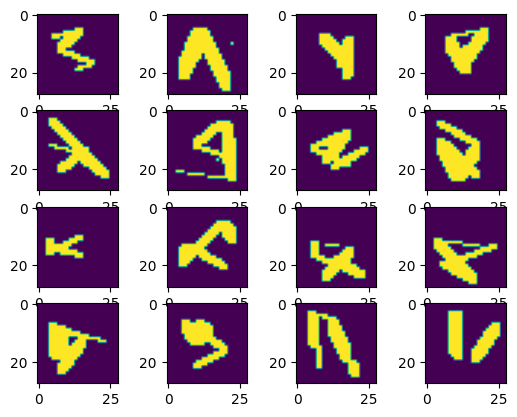

In [105]:

# making random masks :
# we generate some random points in a 28*28 tensor then we
# fill between them with thick lines
x = torch.zeros(60000,28,28).cuda()
num_samp = 2000
mask = torch.zeros(50000,28,28).cuda()
num_random_points = 6
random_points = torch.randint(3,25,[x.size(0),num_random_points, 2],dtype=torch.int8).cuda()
random_points1 = torch.cat( (13+random_points[:num_samp,2,1].reshape(-1,1)//2,2+random_points[:num_samp,0,0].reshape(-1,1)),1)
random_points2 = torch.cat((2+random_points[:num_samp,1,1].reshape(-1,1),13+random_points[:num_samp,1,0].reshape(-1,1)//2),1)
random_points3 = torch.cat((2+random_points[:num_samp,0,1].reshape(-1,1)//2,2+random_points[:num_samp,0,0].reshape(-1,1)//2),1)
random_points4 = random_points[:num_samp,3:6,:]
random_points = torch.cat((random_points1.reshape(-1,1,2), random_points2.reshape(-1,1,2), random_points3.reshape(-1,1,2), random_points4), 1)
# print(random_points)
mat = torch.randint(6,23,[5,2, 2]).cuda()

for i in range(num_samp):
  for rnd_pt_x1, rnd_pt_x2 in random_points[i,:,:]:
    # print(rnd_pt_x1,rnd_pt_x2)
    # print(type(rnd_pt_x1.item()),type(rnd_pt_x1.item()))
    mask[i, rnd_pt_x1, rnd_pt_x2] = 1

# plt.imshow(mask[0,:,:].cpu(), cmap="gray")
# plt.show()

# plt.imshow(mask[1,:,:].cpu(), cmap="gray")
# plt.show()

print("generating random masks:")

for j in tqdm(range(num_samp)):
  random_point = random_points[j,:,:]
  for i,(pt_x1, pt_y1) in enumerate(random_point[1:]):
    (pt_x0, pt_y0) = random_point[i,:]
    m = (pt_y1-pt_y0)/(pt_x1-pt_x0)
    d = pt_y1-m*pt_x1
    # print("*"*20, pt_x1, pt_y1)
    for x_ in range(min(pt_x0,pt_x1), max(pt_x0,pt_x1)+1):
      for y_ in range(min(pt_y0,pt_y1), max(pt_y0,pt_y1)+1):
        # print(x_,y_)
        if abs(y_ -m * x_ - d) < 3 :  # or torch.pow(x_-pt_x0,2)+torch.pow(y_-pt_y0,2)<37
          mask[j,x_,y_] = 1
# plt.imshow(mask[0,:,:].cpu(), cmap="gray")
# plt.show()

# plt.imshow(mask[1,:,:].cpu(), cmap="gray")
# plt.show()
final_mask = torch.zeros(2000,28*28).cuda()
sum_mas = torch.sum(mask.reshape(-1,28*28),1)
ptr = 0
for i in range(len(final_mask)):
  # print(sum_mas[i])
  if 30<sum_mas[i]<160:
    final_mask[ptr,:] = mask[i,:,:].flatten()
    ptr+=1
i=0
while ptr<2000:
  final_mask[ptr,:] = mask[i,:,:].flatten()
  i+=1
  ptr+=1

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(mask[i,:,:].cpu())
final_mask = final_mask.repeat(25,1)
rp = torch.randperm(50000)
final_mask = final_mask[rp,:]

In [128]:

torch.manual_seed(0)
train_loader, test_loader = MNIST_loaders()

x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()

rnd1 = torch.randperm(x.size(0))
rnd2 = torch.randperm(x.size(0))
x_pos = x
x_neg = x * final_mask + (1-final_mask) * x[rnd2,:]

print(x.shape)

# plt.imshow(x_neg[1,:].reshape(28,28).cpu(), cmap="gray")
# plt.show()

# plt.imshow(x_neg[55,:].reshape(28,28).cpu(), cmap="gray")
# plt.show()


torch.Size([50000, 784])


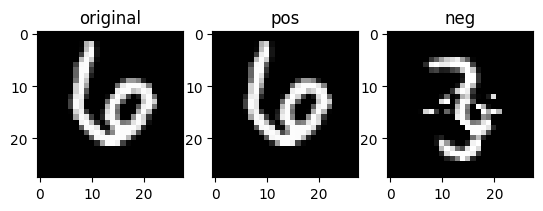

training layer 0 ...


100%|██████████| 1000/1000 [01:04<00:00, 15.60it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:40<00:00, 24.51it/s]


training layer 2 ...


100%|██████████| 1000/1000 [00:41<00:00, 24.38it/s]


In [129]:

net = Net([784, 500, 500,500])
original_pos_neg_image(x, x_pos, x_neg)


net.train(x_pos, x_neg)


In [131]:
epochs = 100
ff_output_neurons = net.output_neurons

linear_classifier = LinearClassifier(ff_output_neurons, net)
print("training the final linear classifier")
linear_classifier.train(x,y,epochs)

training the final linear classifier


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


training the final linear classifier


  0%|          | 0/100 [00:00<?, ?it/s]

In [135]:
print('train accuracy:', linear_classifier.test(x).eq(y).float().mean().item())


x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

print('test accuracy:', linear_classifier.test(x_test).eq(y_test).float().mean().item())

train accuracy: 0.9170599579811096
test accuracy: 0.9170999526977539
